In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import median_abs_deviation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

df1 = pd.read_csv('./data/Active_Users.csv')
df2 = pd.read_csv('./data/Avg_Session_Duration.csv')
df3 = pd.read_csv('./data/Pageviews.csv')

dataframes = [df1, df2, df3]

for df in dataframes:
    df['Day Index'] = pd.to_datetime(df['Day Index'], errors='coerce')

dataframes[1]['Avg. Session Duration'] = pd.to_timedelta(dataframes[1]['Avg. Session Duration'], errors='coerce')

dataframes[0]['1 Day Active Users'] = dataframes[0]['1 Day Active Users'].str.replace(',', '').astype(int, errors='ignore')

dataframes[2]['Pageviews'] = dataframes[2]['Pageviews'].str.replace(',', '').astype(int, errors='ignore')

In [2]:
dataframes[0].head()

,Day Index,1 Day Active Users
0,2021-05-01,1331
1,2021-05-02,1429
2,2021-05-03,2194
3,2021-05-04,2399
4,2021-05-05,2444


In [3]:
dataframes[1].head()

,Day Index,Avg. Session Duration
0,2021-05-01,0 days 00:01:35
1,2021-05-02,0 days 00:01:12
2,2021-05-03,0 days 00:01:23
3,2021-05-04,0 days 00:01:03
4,2021-05-05,0 days 00:01:07


In [4]:
dataframes[2].head()

,Day Index,Pageviews
0,2021-05-01,6194
1,2021-05-02,6545
2,2021-05-03,11755
3,2021-05-04,11706
4,2021-05-05,12171


In [5]:
# Function to compute MAD and z-score
def compute_robust_z_score(x):
    return .6745 * (x - median) / mad

# Function to detect anomalies using Isolation Forest
def detect_anomalies_isolation_forest(df, column_name):
    contamination = 0.005
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(df[column_name].values.reshape(-1, 1))
    preds = iso_forest.predict(df[column_name].values.reshape(-1, 1))
    return preds

# Function to detect anomalies using Local Outlier Factor
def detect_anomalies_lof(df, column_name):
    contamination = 0.005
    lof = LocalOutlierFactor(contamination=contamination, novelty=True)
    lof.fit(df[column_name].values.reshape(-1, 1))
    preds = lof.predict(df[column_name].values.reshape(-1, 1))
    return preds

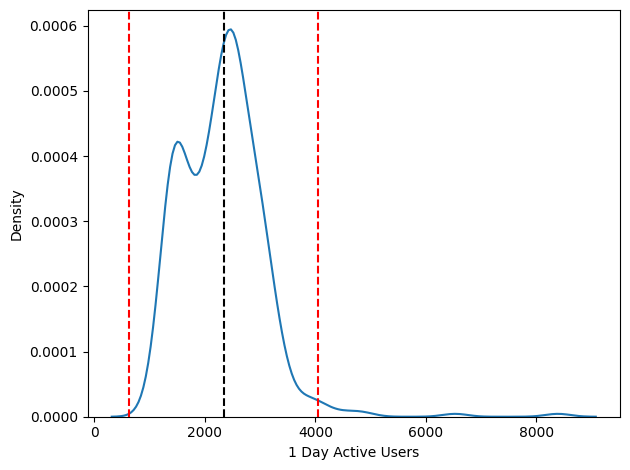

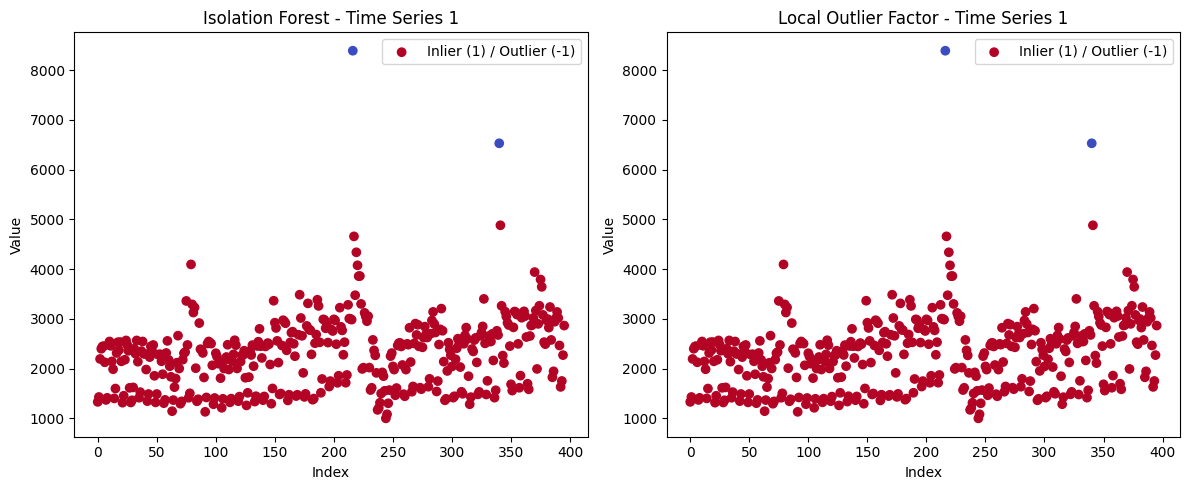

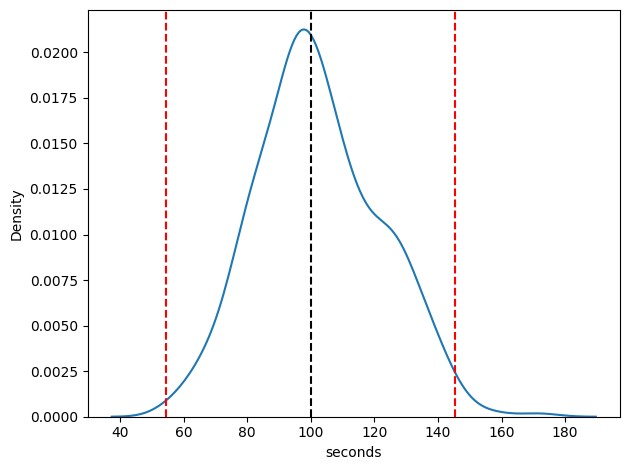

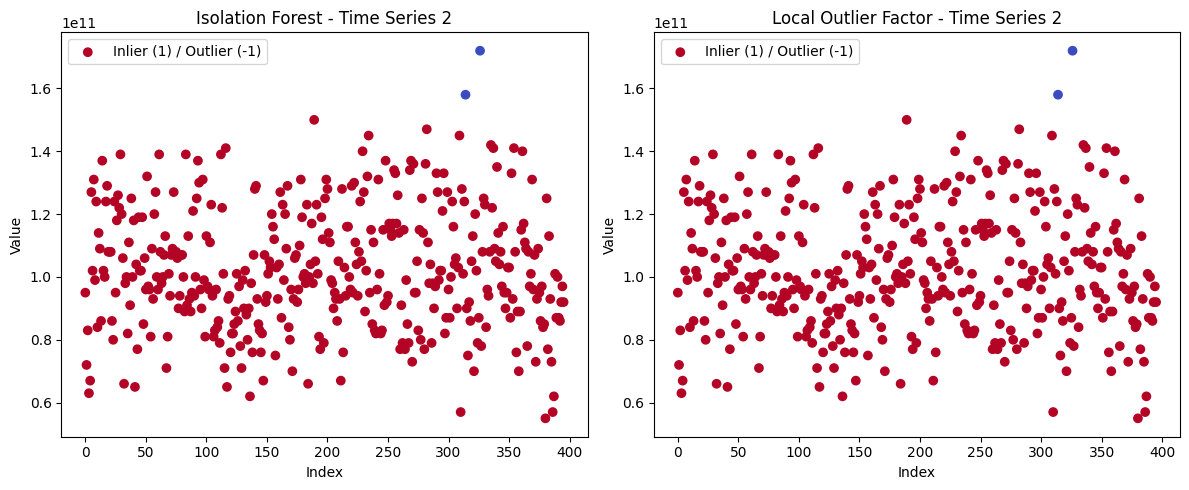

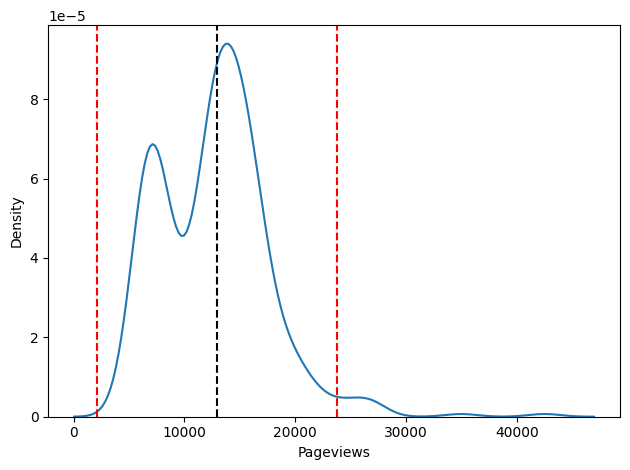

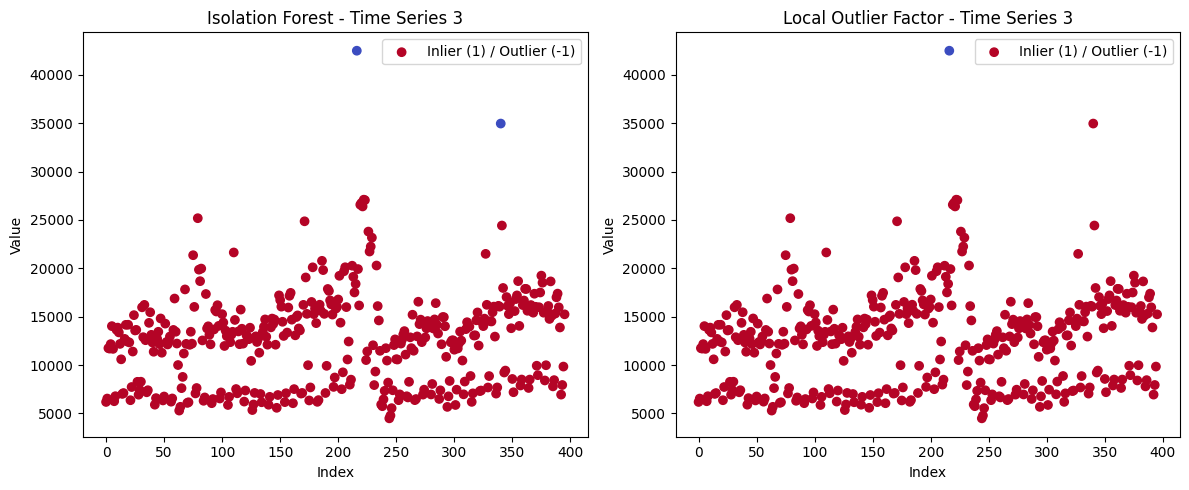

In [6]:
import seaborn as sns

for i, df in enumerate(dataframes, start=1):
    column_names = df.columns.tolist()
    
    if column_names[1] == 'Avg. Session Duration':
        # Convert timedelta to seconds (numeric)
        df['seconds'] = df[column_names[1]].dt.total_seconds()
        median = np.median(df['seconds'])
        mad = median_abs_deviation(df['seconds'])
    else:
        median = np.median(df[column_names[1]])
        mad = median_abs_deviation(df[column_names[1]])

    # Plot KDE
    if column_names[1] == 'Avg. Session Duration':
        sns.kdeplot(df['seconds']);  # Assuming 'seconds' contains numeric data
    else:
        sns.kdeplot(df[column_names[1]]);  # Plot the original column data
    plt.grid(False)
    plt.axvline(median, 0, 1, c='black', ls='--', label='Median')
    plt.axvline(median + 3.5 * mad, 0, 1, c='red', ls='--', label='Upper Bound (3.5 MAD)')
    plt.axvline(median - 3.5 * mad, 0, 1, c='red', ls='--', label='Lower Bound (3.5 MAD)')
    plt.tight_layout()
    
    # Compute z-score
    if column_names[1] == 'Avg. Session Duration':
        df['z-score'] = compute_robust_z_score(df['seconds'])
    else:
        df['z-score'] = compute_robust_z_score(df[column_names[1]])

    # Detect anomalies using Isolation Forest
    df['baseline_iso_forest'] = detect_anomalies_isolation_forest(df, column_names[1])
    
    # Detect anomalies using Local Outlier Factor
    df['baseline_lof'] = detect_anomalies_lof(df, column_names[1])
    
    # Plot results (omitting confusion matrix evaluation)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(df.index, df[column_names[1]], c=df['baseline_iso_forest'], cmap='coolwarm', label='Inlier (1) / Outlier (-1)')
    ax[0].set_title(f'Isolation Forest - Time Series {i}')
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    
    ax[1].scatter(df.index, df[column_names[1]], c=df['baseline_lof'], cmap='coolwarm', label='Inlier (1) / Outlier (-1)')
    ax[1].set_title(f'Local Outlier Factor - Time Series {i}')
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()


In [8]:
print(dataframes)

[     Day Index  1 Day Active Users   z-score  baseline_iso_forest  \
0   2021-05-01                1331 -1.392538                    1   
1   2021-05-02                1429 -1.257086                    1   
2   2021-05-03                2194 -0.199724                    1   
3   2021-05-04                2399  0.083621                    1   
4   2021-05-05                2444  0.145819                    1   
..         ...                 ...       ...                  ...   
391 2022-05-27                2465  0.174845                    1   
392 2022-05-28                1632 -0.976505                    1   
393 2022-05-29                1751 -0.812026                    1   
394 2022-05-30                2271 -0.093297                    1   
395 2022-05-31                2865  0.727714                    1   

     baseline_lof  
0               1  
1               1  
2               1  
3               1  
4               1  
..            ...  
391             1  
392       

In [9]:
dataframes[0].to_csv('./results/Active_Users_results.csv', index=False)
dataframes[1].to_csv('./results/Avg_Session_Duration_results.csv', index=False)
dataframes[2].to_csv('./results/Pageviews_results.csv', index=False)